In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
import json
import time


In [30]:
df = pkl.load(open('project8.pkl', 'rb'))
print(df.shape)
df.head()

(2027, 19)


,Unnamed: 0,post_id,self_text,user_is_verified,controversiality,ups,downs,subreddit,score,user_awardee_karma,user_awarder_karma,user_total_karma,user_comment_karma,user_link_karma,post_score,post_upvote_ratio,post_thumbs_up,post_total_awards_ratio,post_created_time
0,1979,9grgvl,"Yes, modeling anything with less resolution i...",True True True True True True True,0.142857,2.857143,0,climate_science,2.857143,8.571429,0.000000,11034.571429,10438.285714,587.714286,33,0.97,33,0,2018-09-18 03:59:40
1,503,1anritd,"Thing is, there's no official paper that desc...",True True True True True True True,0.000000,9.000000,0,climateskeptics,9.000000,748.142857,9.571429,91926.000000,42031.571429,49136.714286,67,0.94,67,0,2024-02-10 21:56:09
2,1387,16xyvqf,I read that article a month ago. Not sure wh...,True,0.000000,2.000000,0,climateskeptics,2.000000,315.000000,0.000000,37103.000000,36305.000000,483.000000,7,0.73,7,0,2023-10-02 14:58:12
3,918,18ii60q,&gt; Dr. Paul Pettré provides a damning critq...,True,0.000000,3.000000,0,climateskeptics,3.000000,1683.000000,20.000000,164653.000000,63989.000000,98961.000000,12,0.93,12,0,2023-12-14 20:42:33
4,1375,16zuc0a,This was a really good interview. She really ...,False,0.000000,3.000000,0,climateskeptics,3.000000,1703.000000,114.000000,1817.000000,0.000000,0.000000,27,0.97,27,0,2023-10-04 18:12:08


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               2027 non-null   int64  
 1   post_id                  2027 non-null   object 
 2   self_text                2027 non-null   object 
 3   user_is_verified         2027 non-null   object 
 4   controversiality         2027 non-null   float64
 5   ups                      2027 non-null   float64
 6   downs                    2027 non-null   int64  
 7   subreddit                2027 non-null   object 
 8   score                    2027 non-null   float64
 9   user_awardee_karma       2022 non-null   float64
 10  user_awarder_karma       2022 non-null   float64
 11  user_total_karma         2022 non-null   float64
 12  user_comment_karma       2022 non-null   float64
 13  user_link_karma          2022 non-null   float64
 14  post_score              

### Task 1

In [32]:
df["preprocessed_text"] = df["self_text"].apply(lambda x: x.lower())

In [33]:
stop_words = set(stopwords.words('english'))
df["tokenized_text"] = df["preprocessed_text"].apply(lambda x: word_tokenize(x))
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in stop_words])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word.isalnum()])
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if len(word) > 1]) # remove single character words, this can help with removing punctuation. 


In [34]:
#group by subreddit
grouped = df.groupby('subreddit')
df_cli_sci = grouped.get_group('climate_science')
df_cli_skp = grouped.get_group('climateskeptics')

print(df_cli_sci.shape)
print(df_cli_skp.shape)

(442, 21)
(1585, 21)


In [35]:
cli_sci_words = [word for words in df_cli_sci["tokenized_text"].values for word in words]
cli_skp_words = [word for words in df_cli_skp["tokenized_text"].values for word in words]

In [36]:
print(len(cli_sci_words))
print(len(cli_skp_words))

123994
487206


In [37]:
common_words = set()
with open ("common_words.txt", "r") as f:
    for line in f:
        common_words.add(line.strip())
        
print(len(common_words))

cli_sci_words = [word for word in cli_sci_words if word not in common_words]
cli_skp_words = [word for word in cli_skp_words if word not in common_words]

print(len(cli_sci_words))
print(len(cli_skp_words))


63
99671
393779


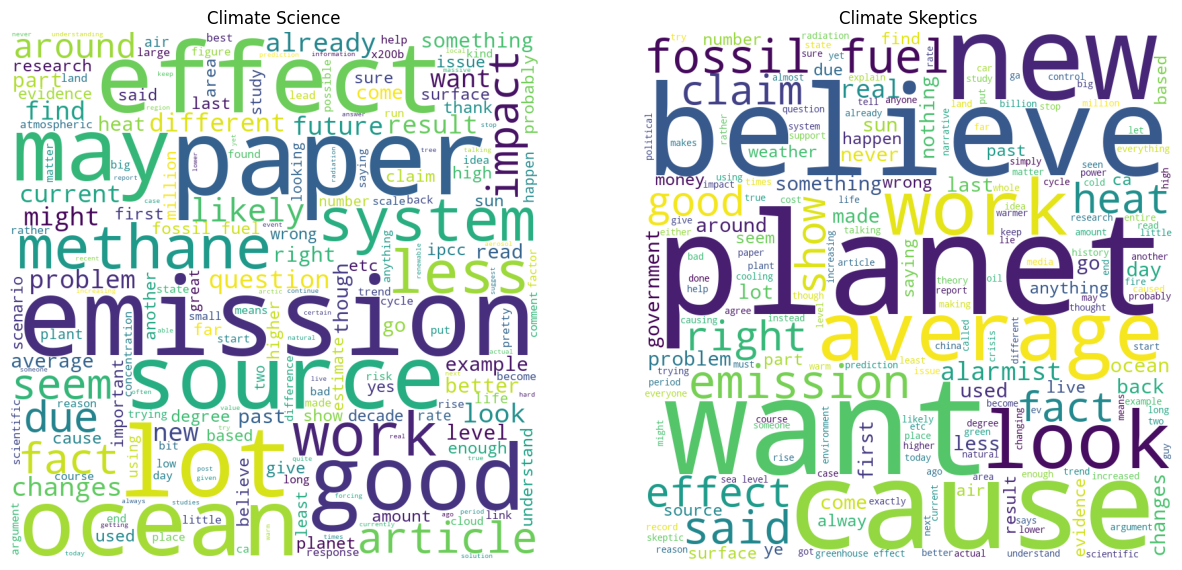

In [38]:
#word cloud for climate science and climate skeptics in subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

wordcloud_cli_sci = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_sci_words))
ax[0].imshow(wordcloud_cli_sci)
ax[0].axis('off')
ax[0].set_title('Climate Science')

wordcloud_cli_skp = WordCloud(width=800, height=800, background_color='white').generate(' '.join(cli_skp_words))
ax[1].imshow(wordcloud_cli_skp)
ax[1].axis('off')
ax[1].set_title('Climate Skeptics')

plt.show()

In [39]:
from collections import Counter

total_cli_sci_words = len(cli_sci_words)
total_cli_skp_words = len(cli_skp_words)

cli_sci_word_freq = Counter({word: count / total_cli_sci_words for word, count in Counter(cli_sci_words).items()})
cli_skp_word_freq = Counter({word: count / total_cli_skp_words for word, count in Counter(cli_skp_words).items()})

print(cli_sci_word_freq.most_common(20))
print(cli_skp_word_freq.most_common(20))


[('emissions', 0.004013203439315348), ('methane', 0.0032807938116402964), ('good', 0.0028995394849053386), ('paper', 0.002367790029196055), ('lot', 0.002357757020597767), ('ocean', 0.00227749295181146), ('heat', 0.0022674599432131715), ('may', 0.0022574269346148828), ('effect', 0.0021871958744268645), ('less', 0.0021771628658285762), ('likely', 0.002116964814238846), ('ipcc', 0.0020968987970422692), ('since', 0.002066799771247404), ('might', 0.0020166347282559623), ('greenhouse', 0.001996568711059385), ('due', 0.0019765026938628086), ('already', 0.0019464036680679436), ('around', 0.0019464036680679436), ('different', 0.0019464036680679436), ('changes', 0.0019263376508713668)]
[('heat', 0.0031185004786949025), ('planet', 0.002897564369862283), ('effect', 0.0028163005137399402), ('gas', 0.002595364404907321), ('greenhouse', 0.0024074417376244036), ('since', 0.002211900583830016), ('oil', 0.0022042820973185466), ('weather', 0.002196663610807077), ('believe', 0.002171268655768845), ('new',

In [40]:
#after we have made a list of common words, we can remove them from the tokenized text
df["tokenized_text"] = df["tokenized_text"].apply(lambda x: [word for word in x if word not in common_words])
df["preprocessed_text"] = df["tokenized_text"].apply(lambda x: ' '.join(x)) # convert back to string, now each observation is a string of words that has been cleaned


### Task 2

In [41]:
 #initialize the vectorizer without any preprocessing
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["preprocessed_text"]) #fitting and transforming the vectorizer on the preprocessed text 
tfidf_matrix = tfidf_matrix.toarray() #convert object matrix to a matrix
print(tfidf_matrix.shape) 

(2027, 30253)


In [42]:
df["tfidf_vector"] = [vector for vector in tfidf_matrix] #store the vectors in the dataframe for later use

In [43]:
most_prominent_words = ['emission', 'source', 'planet', 'believe']
#find the indices of the most prominent words in the tfidf features 
word_indices = [tfidf_vectorizer.vocabulary_[word] for word in most_prominent_words]
#find the cosine similarity between the most prominent words
cosine_similarities = cosine_similarity(tfidf_matrix[:, word_indices].T)
#store the cosine similarities in a dataframe
cosine_similarities_df = pd.DataFrame(cosine_similarities, columns=most_prominent_words, index=most_prominent_words)
print(cosine_similarities_df)

          emission    source    planet   believe
emission  1.000000  0.078340  0.090723  0.044319
source    0.078340  1.000000  0.119099  0.123720
planet    0.090723  0.119099  1.000000  0.232975
believe   0.044319  0.123720  0.232975  1.000000


### Task 3

In [44]:
# Traning a) Logistic Regression b) Random Forest c) Naive Bayes d) SVM  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

X = np.array(df["tfidf_vector"].values.tolist())
y = df["subreddit"].values
y = np.array([1 if subreddit == 'climate_science' else 0 for subreddit in y]) #convert the subreddit names to binary values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [64]:
def train_and_test(model, X_train, X_test, y_train, y_test):
    time_start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
    time_elapsed = (time.time() - time_start)
    
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'time_elapsed(s)': time_elapsed}

In [65]:
classifiers = [
    ("Logistic Regression", LogisticRegression()), 
    ("Random Forest", RandomForestClassifier()), 
    ("Naive Bayes", MultinomialNB()), 
    ("SVM", SVC())
]
results = {}

for classifier in classifiers:
    name, model = classifier
    results[name] = train_and_test(model, X_train, X_test, y_train, y_test)

c:\Users\randy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [70]:
def print_results(results):
    print("----------------------------------------------")
    for name, result in results.items():
        print(f'{name}:')
        print(f'Accuracy: {result["accuracy"]}')
        print(f'Precision: {result["precision"]}')
        print(f'Recall: {result["recall"]}')
        print(f'F1: {result["f1"]}')
        print(f'Time Elapsed (s): {result["time_elapsed(s)"]}')
        print("----------------------------------------------")

In [71]:
print_results(results)

----------------------------------------------
Logistic Regression:
Accuracy: 0.8029556650246306
Precision: [0.80050505 0.9       ]
Recall: [0.99685535 0.10227273]
F1: [0.88795518 0.18367347]
Time Elapsed (s): 0.4820713996887207
----------------------------------------------
Random Forest:
Accuracy: 0.8054187192118226
Precision: [0.80100756 1.        ]
Recall: [1.         0.10227273]
F1: [0.88951049 0.18556701]
Time Elapsed (s): 9.392178535461426
----------------------------------------------
Naive Bayes:
Accuracy: 0.7832512315270936
Precision: [0.78325123 0.        ]
Recall: [1. 0.]
F1: [0.87845304 0.        ]
Time Elapsed (s): 0.0707709789276123
----------------------------------------------
SVM:
Accuracy: 0.8078817733990148
Precision: [0.80456853 0.91666667]
Recall: [0.99685535 0.125     ]
F1: [0.89044944 0.22      ]
Time Elapsed (s): 42.432440996170044
----------------------------------------------


### Task 4

In [72]:
#function to prune the features
def select_k(k):
    selector = SelectKBest(chi2, k=k)
    X_train_k = selector.fit_transform(X_train, y_train)
    X_test_k = selector.transform(X_test)
    
    return X_train_k, X_test_k

In [73]:
pruned_results = {}

In [74]:
k_s = [25000, 20000, 15000, 10000, 5000]

for k in k_s:
    X_train_k, X_test_k = select_k(k)
    pruned_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)

In [75]:
print_results(pruned_results)

----------------------------------------------
RandomForest_25000:
Accuracy: 0.8029556650246306
Precision: [0.80050505 0.9       ]
Recall: [0.99685535 0.10227273]
F1: [0.88795518 0.18367347]
Time Elapsed (s): 3.546546697616577
----------------------------------------------
RandomForest_20000:
Accuracy: 0.8103448275862069
Precision: [0.80661578 0.92307692]
Recall: [0.99685535 0.13636364]
F1: [0.89170183 0.23762376]
Time Elapsed (s): 3.1043074131011963
----------------------------------------------
RandomForest_15000:
Accuracy: 0.8078817733990148
Precision: [0.80456853 0.91666667]
Recall: [0.99685535 0.125     ]
F1: [0.89044944 0.22      ]
Time Elapsed (s): 2.6670517921447754
----------------------------------------------
RandomForest_10000:
Accuracy: 0.8201970443349754
Precision: [0.81491003 0.94117647]
Recall: [0.99685535 0.18181818]
F1: [0.89674682 0.3047619 ]
Time Elapsed (s): 2.1349074840545654
----------------------------------------------
RandomForest_5000:
Accuracy: 0.81527093596

In [76]:
#select top k features using tfidf
def select_k_tfidf(k):
    #sum the tfidf scores for each word
    word_scores = np.sum(tfidf_matrix, axis=0)
    #get the indices of the top k words
    top_k_indices = np.argsort(word_scores)[-k:] #sort the indices in ascending order and get the last k indices
    
    X_train_k = X_train[:, top_k_indices] #select the top k features from the training set
    X_test_k = X_test[:, top_k_indices] #select the top k features from the test set
    
    return X_train_k, X_test_k

In [77]:
pruned_tfidf_results = {}

for k in k_s:
    X_train_k, X_test_k = select_k_tfidf(k)
    pruned_tfidf_results[f'RandomForest_{k}'] = train_and_test(RandomForestClassifier(), X_train_k, X_test_k, y_train, y_test)
    
print_results(pruned_tfidf_results)

----------------------------------------------
RandomForest_25000:
Accuracy: 0.8054187192118226
Precision: [0.80253165 0.90909091]
Recall: [0.99685535 0.11363636]
F1: [0.88920056 0.2020202 ]
Time Elapsed (s): 3.572510004043579
----------------------------------------------
RandomForest_20000:
Accuracy: 0.8029556650246306
Precision: [0.80050505 0.9       ]
Recall: [0.99685535 0.10227273]
F1: [0.88795518 0.18367347]
Time Elapsed (s): 3.145131826400757
----------------------------------------------
RandomForest_15000:
Accuracy: 0.812807881773399
Precision: [0.80867347 0.92857143]
Recall: [0.99685535 0.14772727]
F1: [0.89295775 0.25490196]
Time Elapsed (s): 2.785940170288086
----------------------------------------------
RandomForest_10000:
Accuracy: 0.8054187192118226
Precision: [0.8056266 0.8      ]
Recall: [0.99056604 0.13636364]
F1: [0.88857546 0.23300971]
Time Elapsed (s): 2.3432507514953613
----------------------------------------------
RandomForest_5000:
Accuracy: 0.8152709359605911

### Task 5

In [ ]:
#Add metadata features
optimal_k = 5000  
X_train_k, X_test_k = select_k(optimal_k)

metadata_features = ["score", 
                     "controversiality", 
                     "ups", 
                     "user_awardee_karma", 
                     "user_awarder_karma", 
                     "user_total_karma", 
                     "user_comment_karma", 
                     "user_link_karma",
                     "post_score",             
                     "post_upvote_ratio",         
                     "post_thumbs_up",              
                     "post_total_awards_ratio", 
                     "post_year"    
                     ]